In [1]:
#%matplotlib notebook

In [2]:
import time
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from skimage.filters import gaussian

import math

from datetime import date
from collections import OrderedDict
from glob import glob
from scipy import ndimage
from skimage import img_as_float, io
import imageio
import json

## Overview

This code is used to take a large image and then split it into individual components which will be processed separately (stardist), and then stitch them back together afterwards to form a processed version of the original. Ideally, the raw image file, the grid overlaid image, as well as the post-processed image will all be retained.

The steps to achieve this are as follows:

1. Input image


2. Image slicer
    - overlay a grid, with overlapping cells
    - create subimages based on cell coordinates
    - save subimages to a created folder on disk
    - save coordinates of subimages that will be serialized into a json file in the same folder
    
    
3. Process subimage tiles
    - stardist segmentation


4. Reconstruct processed version of original image
    - separate file from raw original


5. Output should be the original image, the subimage tiles, and the post-processed construct

Object segmentation through stardist is computationally expensive and has an upper limit on image file size, so by breaking the original into more manageable subimages, this should mitigate the issue.

## Code mechanics

We begin by pulling information about the dimensions of the image using `.shape`:

```
sample.shape
(21504, 19558)
```
Then set up our parameters:

```
tile_step = 2000
tile_size = 2048

```

- `tile_step` is the increment along the x and y axis which will determine the size of the overall grid

- `tile_size` is the size of individual grid cells
Note that the `tile_size` is larger than `tile_step` (2048 vs. 2000), thus causing overlaps from tile to tile. This is intentional to accomodate for objects that are split along gridlines. The overlaps serve as a buffer zone so that split objects can be stitched together later.

We calculate how many tiles will fit across the length and width of the image:

```
length = math.ceil(sample.shape[0]/tile_step)
width = math.ceil(sample.shape[1]/tile_step)
print(length)
print(width)

11
10
```

### Setting up the loop

```
tile_range_r = np.arange(0, sample.shape[0]+tile_size, tile_step)
tile_range_c = np.arange(0, sample.shape[1]+tile_size, tile_step)
```

- `tile_range` consists of values from 0 to the ceiling of `shape` values + `tile_size`, in increments of `tile_step`, effectively a list of row/column length. The addition of one increment of `tile_size` to the `shape` value ensures that the range fully covers the size of the image being processed. The overhang is negligible as it will not affect the creation of a grid.

---
Using our current values, our outputs are:
```
tile_range_r
[0, 2000, 4000, 8000, 10000, 12000, 14000, 16000, 18000, 20000, 22000]

tile_range_c
[0, 2000, 4000, 8000, 10000, 12000, 14000, 16000, 18000, 20000]
```

---

### Integrating meshgrid

```
xs, ys = np.meshgrid(tile_range_r, tile_range_c, indexing='ij')
```

`meshgrid` is a method where a cartesian grid is generated given certain parameters. In this case, our grid is composed of coordinates given by `tile_range_r` and `tile_range_c`. Indexing has been changed from cartesian to matrix indexing. This will set up the overlay that we need.

### Main `for` loop

```
for ii, tile in enumerate(rs.ravel()):
    
    r_min = rs.ravel()[ii]
    r_max = np.min([rs.ravel()[ii]+tile_size, sample.shape[0]])
    
    c_min = cs.ravel()[ii]
    c_max = np.min([cs.ravel()[ii]+tile_size, sample.shape[1]])
        
    sub_image = sample[r_min:r_max,c_min:c_max]
    img_coordinates.append([r_min, r_max, c_min, c_max])
```

we begin by defining variables to capture the edges of the subimage tiles. The `r_max` and `c_max` values are offset by 2048 pixels to introduce the overlap that takes into account edge objects, which will be stitched together post-processing. `sub_image` is defined as all values within the range of `r_min` to `r_max` and `c_min` to `c_max`. And the min/max values themselves are then added to an initialized list, which will keep track of each corner of each subimage tile generated. `ravel` converts the `rs` meshgrid into a 1D array, which can then be iterated through by using the `enumerate` function. In calculating `c_min` and `c_max` the `cs` meshgrid is also flattened by applying the `ravel` method.

---

```
    for i in range((length*width)):
        
        if ii == i:
            
            rect = Rectangle((c_min, r_min), c_max-c_min, r_max-r_min, linewidth=1, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
            
            ax.text(c_min, r_min, str(r_min)+", "+str(c_min))
            
            plt.figure()
            plt.imshow(sub_image)
            
            img_pos['_DAPI_Overview_subimage_'+str(i).zfill(5)] = [int(j) for j in img_coordinates[i]]
```
the nested portion of the loop first calculates how many tiles can cover the raw image, the tile number is then matched to the index of the `ravel` array through a conditional. Once it has, a grid trace is applied to show how the raw image will be subdivided, and then the image tiles are displayed and stored to disk (still working on this part). Lastly, a filename is generated for each subimage, which becomes the keys to a dictionary whose values are the tile coordinates. This will later be serialized into a `json`.  

## Issues

- There is currently an indexing issue with the for loop, as the y-axis is being clipped prematurely. I suspect that this is because of step sizes and rounding issues when assigning values to the tile_range variable.
    - The maximum values for each listed range is the nearest multiple of 2000 below the actual value.
    - Indexing issue has been mitigated by adding the `tile_size` to the `shape` value when calculating x and y ranges


- indexing issue with filename generation
    - fixed by replacing `elif` statements with the `zfill` method

- issue with capturing edge coordinates up to true shape values
    - fixed by changing indexing mode in meshgrid from cartesian to matrix
    
- image slicing of the `for` loop is incomplete
    - some images are not properly displayed, which could mean that the subimage generation is not properly executing
    - it may be an issue with the nested portion of the `for` loop
    - fixed by double-checking the index references for consistency throughout the script, and the nested portion of the `for` loop has been altered slightly (removed `else` statement)

In [3]:
#local machine
sample = img_as_float(io.imread('C:/Users/jv92c/Documents/mFISH/sample_data/DAPI_empty_Overview_cropped.tif'))

In [ ]:
#work machine
sample = img_as_float(io.imread('C:/Users/john.villanueva/OneDrive/Documents/sample_data/DAPI_Overview.tif'))

In [4]:
sample.dtype

dtype('float64')

In [5]:
today = date.today()
sample.shape

(9699, 5893)

In [6]:
#local machine
if not os.path.exists('C:/Users/jv92c/Documents/mFISH/sample_data/DAPI_Overview_subimg'):
    os.makedirs('C:/Users/jv92c/Documents/mFISH/sample_data/DAPI_Overview_subimg')

In [ ]:
#work machine
if not os.path.exists('C:/Users/john.villanueva/OneDrive/Documents/sample_data/DAPI_Overview_subimg'):
    os.makedirs('C:/Users/john.villanueva/OneDrive/Documents/sample_data/DAPI_Overview_subimg')

In [7]:
#slice intervals
tile_step = 2000

#size of the 2D slice
#also determines the overlap between FOVs for use in stitching of edge objects
tile_size = 2100

In [8]:
length = math.ceil(sample.shape[0]/tile_step)
width = math.ceil(sample.shape[1]/tile_step)

print('length = '+ str(length))
print('width = '+ str(width))

length = 5
width = 3


In [9]:
#range in the x-direction determined by width of image; row length
tile_range_r = np.arange(0, sample.shape[0], tile_step)

#range in the y-direction determined by height; column height
tile_range_c = np.arange(0, sample.shape[1], tile_step)

rs, cs = np.meshgrid(tile_range_r, tile_range_c, indexing='ij')

In [10]:
#local machine
output_dir = 'C:/Users/jv92c/Documents/mFISH/sample_data/DAPI_Overview_subimg'

In [ ]:
#work machine
output_dir = 'C:/Users/john.villanueva/OneDrive/Documents/sample_data/DAPI_Overview_subimg'

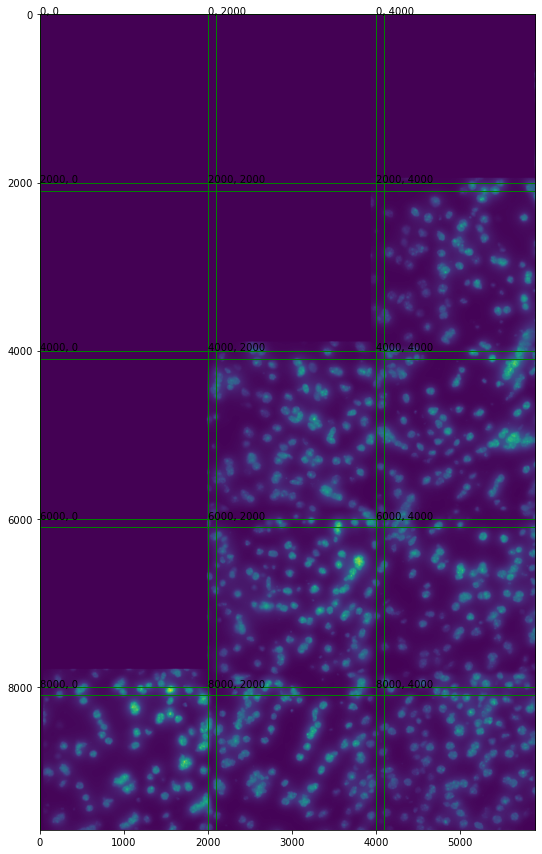

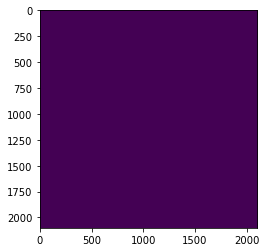

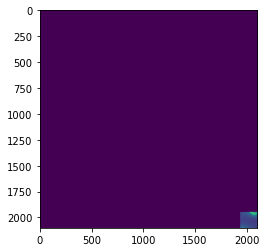

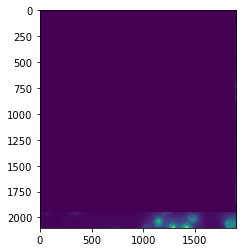

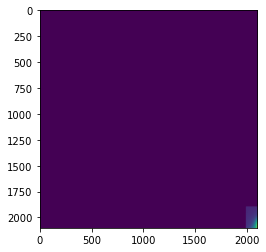

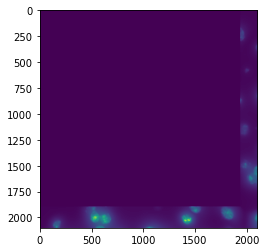

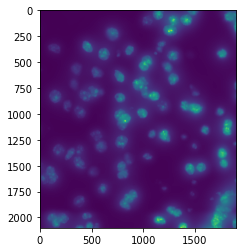

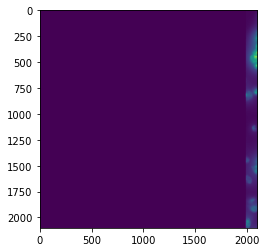

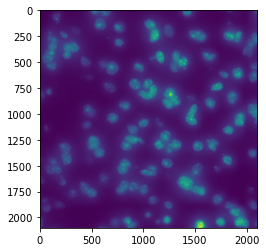

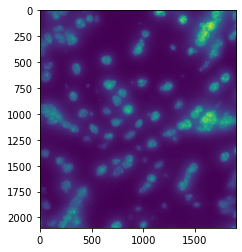

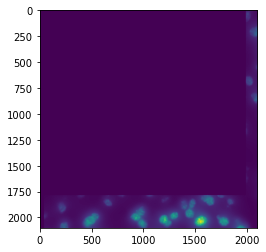

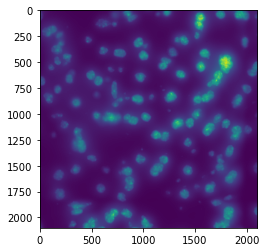

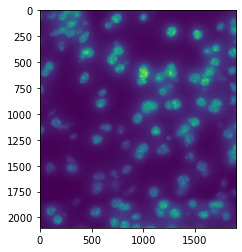

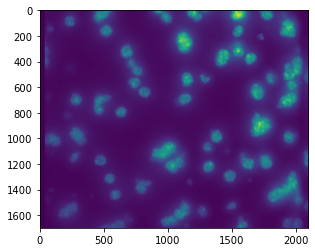

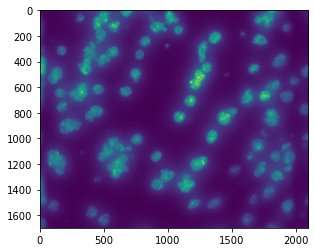

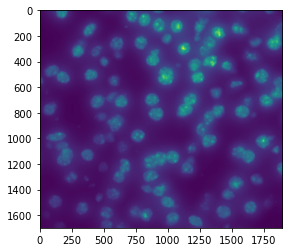

In [11]:
plt.figure(figsize= [15,15])
plt.imshow(sample)
ax = plt.gca()

img_coordinates = []
img_pos = OrderedDict()

for ii, tile in enumerate(rs.ravel()):
    
    #setting the coordinates
    r_min = rs.ravel()[ii]
    r_max = np.min([rs.ravel()[ii]+tile_size, sample.shape[0]])
    
    c_min = cs.ravel()[ii]
    c_max = np.min([cs.ravel()[ii]+tile_size, sample.shape[1]])
        
    sub_image = sample[r_min:r_max,c_min:c_max]
    img_coordinates.append([r_min, r_max, c_min, c_max])
    
    for i in range((length*width)):
        
        if ii == i:
            
            #grid overlay for sample image
            rect = Rectangle((c_min, r_min), c_max-c_min, r_max-r_min, linewidth=1, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
            
            #upper-left corner coordinates of each tile
            ax.text(c_min, r_min, str(r_min)+", "+str(c_min))
            
            # figure to display subimage
            plt.figure()
            plt.imshow(sub_image)
            
            #saving subimages to disk
            imageio.imwrite('{}/DAPI_Overview_subimage_{}.tif'.format(output_dir, str(i).zfill(5)), sub_image)
            
            #creating a dictionary for export to json
            img_pos['DAPI_Overview_subimage_'+str(i).zfill(5)] = [int(j) for j in img_coordinates[i]]
            #add this string <today.strftime("%Y%m%d")+> in front of _DAPI_Overview_subimage if you want to have a timestamp as part of the file handle
            
            

#### Context manager

"w" is a variable, which is the output of the file that is being opened. This variable only exists within the context
of this code block

if the statement is done/fails, the file will still close.
```
# with open(<filename>, 'w') as w:
# json.dump(my_dictionary, w)
```

no need to set up classes, just proper serialization of the json file

In [12]:
#today.strftime("%Y%m%d") for the date
#+str(int(time.time())) for the timestamp

filename = 'DAPI_Overview_subimage_'

In [13]:
#use path to access directory of images
#assuming that they'll be in the same folder post-stardist

with open(filename, 'w') as file:    
    json.dump(img_pos, file)

In [14]:
with open(filename) as file:    
    coordinates = json.load(file, object_pairs_hook=OrderedDict)

#### Reconstructing the image

This segment reads `tif` files stored to disk. 
By using the coordinates stored in the previously generated `json` file, we change values of a zero `ndarray` to that of the subimage tile being read.

First is to read the raw data tiles

In [15]:
#creating a zero array to begin image reconstruction

boundary = []

for key in coordinates:
    boundary.append(coordinates[key])
    
canvas = np.zeros((boundary[-1][1], boundary[-1][3]))

In [16]:
#testing with the original data

for key in coordinates:
    
    '''
    within the zero ndarray, we overlay an image whose corners 
    will be set by the coordinates stored within the dictionary
    '''
    
    canvas[coordinates[key][0]:coordinates[key][1], coordinates[key][2]:coordinates[key][3]] = imageio.imread(output_dir+'/'+'{}.tif'.format(str(key)))

canvas.shape

(9699, 5893)

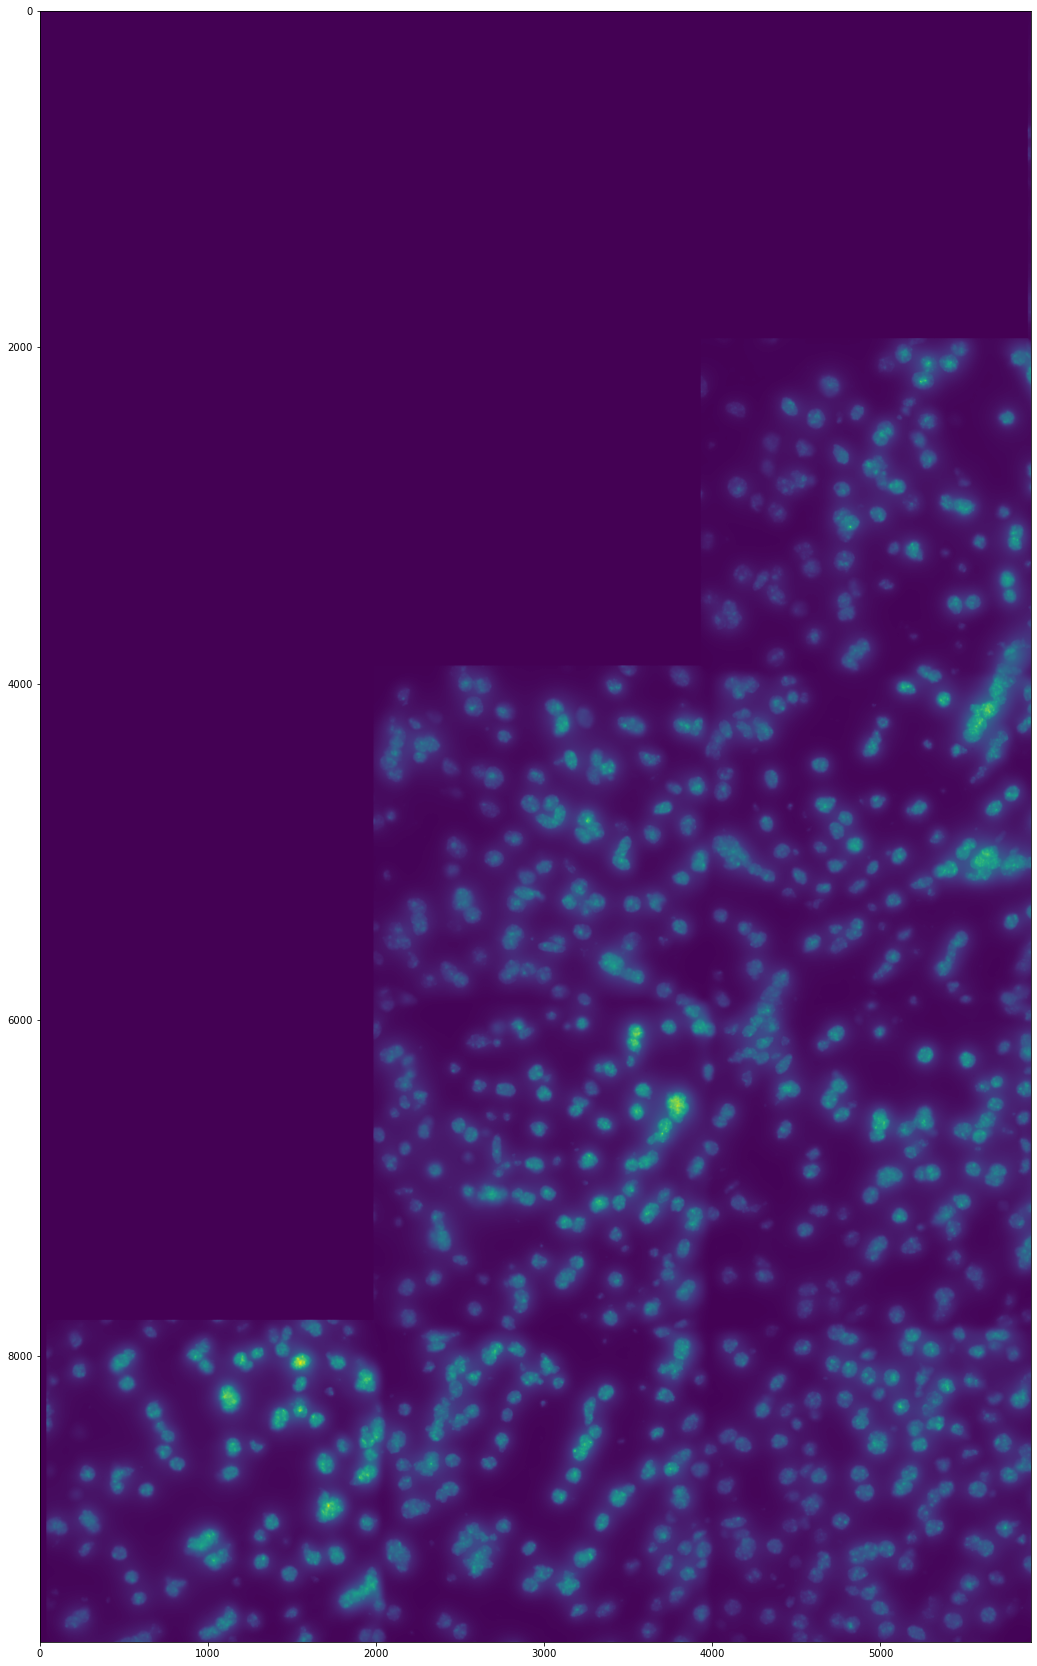

In [17]:
plt.figure(figsize=(30,30))
plt.imshow(canvas)

### Integration of Stardist

We call on the Stardist package to make predictions on the location and shapes of the nuclei within the image.

In [18]:
#importing stardist

from csbdeep.utils import Path, normalize

from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D

import time

model = StarDist2D.from_pretrained('2D_versatile_fluo')
lbl_cmap = random_label_cmap()

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [19]:
#create new subfolder to store segmented images for faster access

if not os.path.exists('C:/Users/jv92c/Documents/mFISH/sample_data/DAPI_Overview_subimg_segmented'):
    os.makedirs('C:/Users/jv92c/Documents/mFISH/sample_data/DAPI_Overview_subimg_segmented')

In [20]:
#local machine
#source for raw images
img_path = 'C:/Users/jv92c/Documents/mFISH/sample_data/DAPI_Overview_subimg/'
img_list = os.listdir(img_path)
axis_norm = (0,1)

In [21]:
#destination folder for processed images
processed_dir = 'C:/Users/jv92c/Documents/mFISH/sample_data/DAPI_Overview_subimg_segmented'

In [23]:
overlay = np.zeros((boundary[-1][1], boundary[-1][3]))
overlay_pos = {}

42.65610122680664


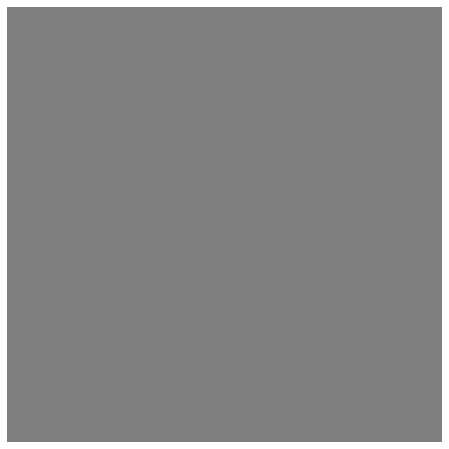

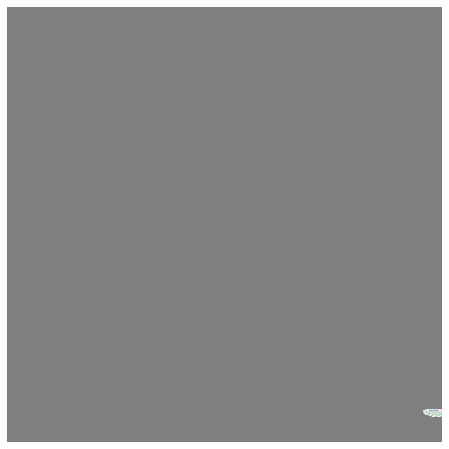

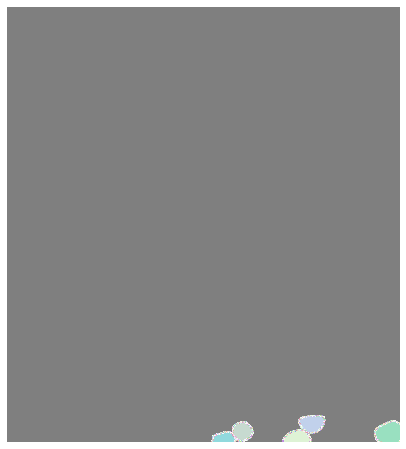

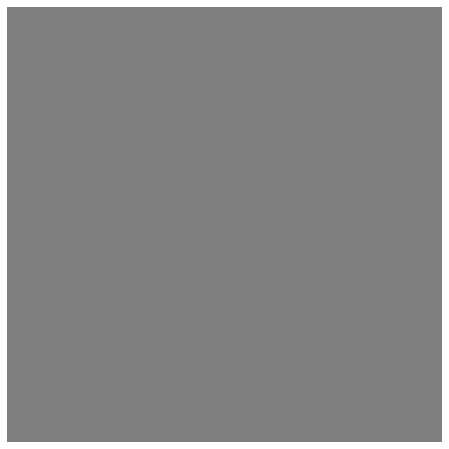

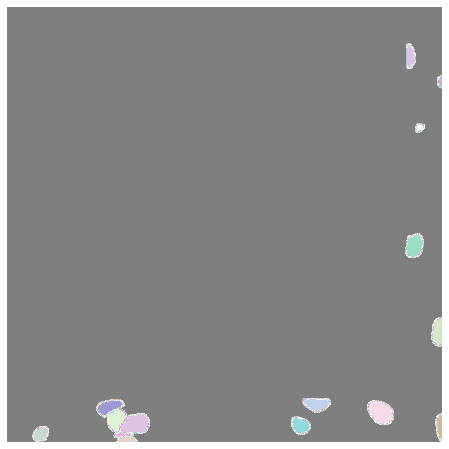

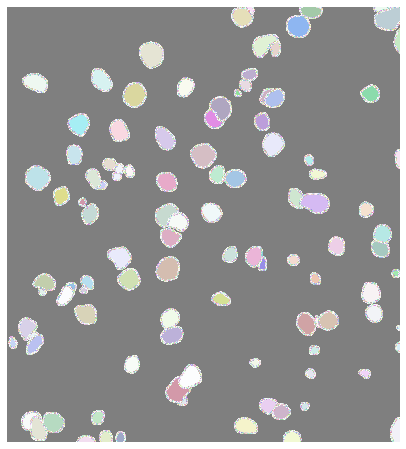

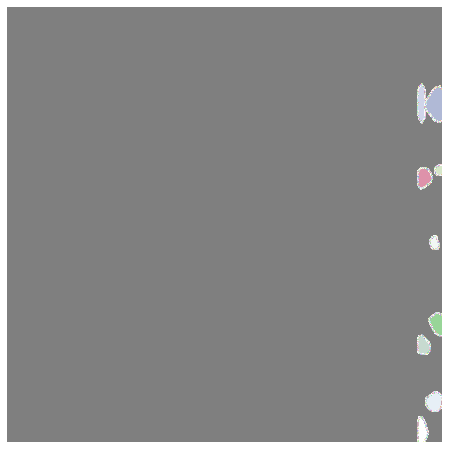

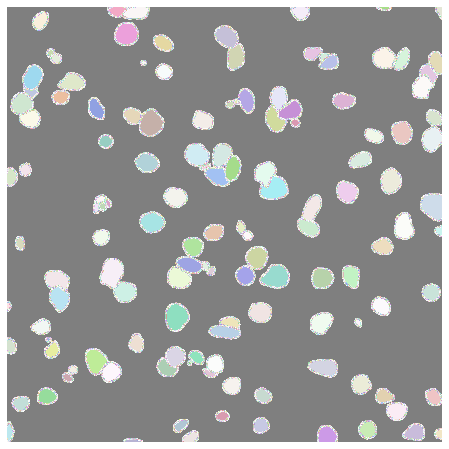

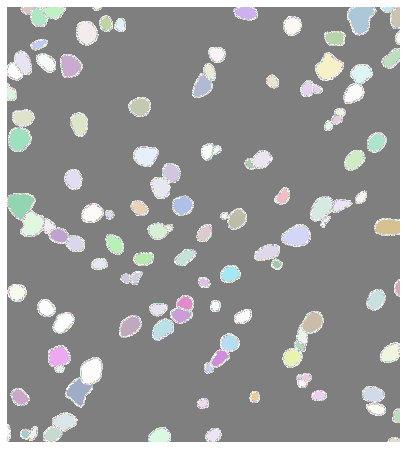

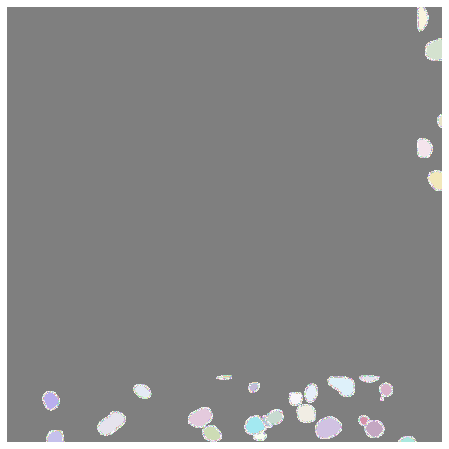

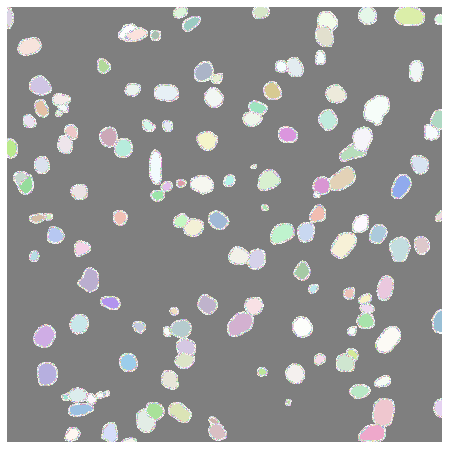

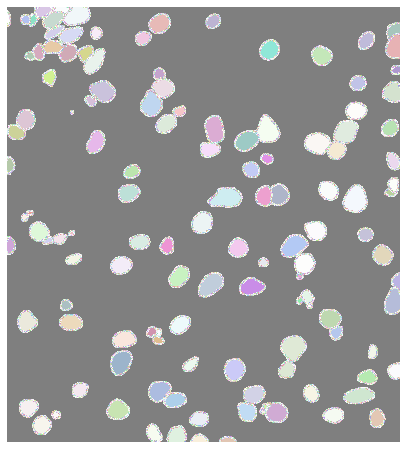

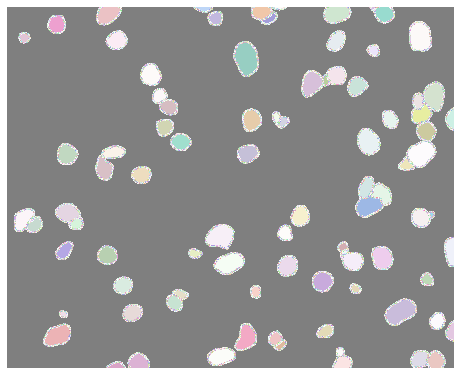

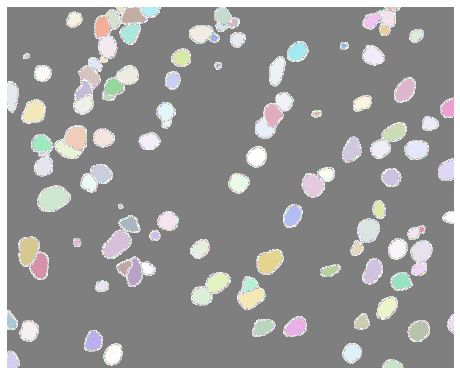

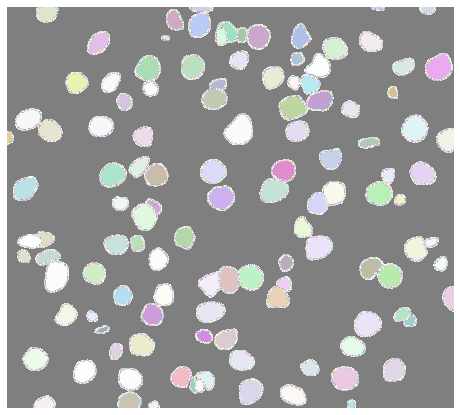

In [24]:
#testing stardist on the sliced images
start = time.time()

for i, img in enumerate(img_list):
    
    subsample = imageio.imread(img_path+img_list[i])
    subsample = normalize(subsample, 1, 99.8, axis=axis_norm)
    labels, details = model.predict_instances(subsample)
        
    plt.figure(figsize=(8,8))
    #plt.imshow(subsample if subsample.ndim==2 else subsample[...,0], clim=(0,1), cmap='gray')
    plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
    plt.axis('off')
    
    #saving subimages to disk
    imageio.imwrite('{}/DAPI_Overview_processed_subimage_{}.tif'.format(processed_dir, str(i).zfill(5)), labels)
    
    #creating a dictionary for the processed tiles
    #leveraging the img_coordinates array generated from the raw image slicer
    overlay_pos['DAPI_Overview_processed_subimage_'+str(i).zfill(5)] = [int(j) for j in img_coordinates[i]]

slicing_time = time.time() - start
print(slicing_time)

In [25]:
processed_files = 'DAPI_Overview_processed_subimage_'

with open(filename, 'w') as file:    
    json.dump(overlay_pos, file)
    
with open(filename) as file:    
    overlay_pos = json.load(file, object_pairs_hook=OrderedDict)

In [26]:
for key in overlay_pos:
    
    '''
    within the zero ndarray, we overlay an image whose corners 
    will be set by the coordinates stored within the dictionary
    '''
    
    overlay[overlay_pos[key][0]:overlay_pos[key][1], overlay_pos[key][2]:overlay_pos[key][3]] = imageio.imread(processed_dir+'/'+'{}.tif'.format(str(key)))

overlay.shape

(9699, 5893)

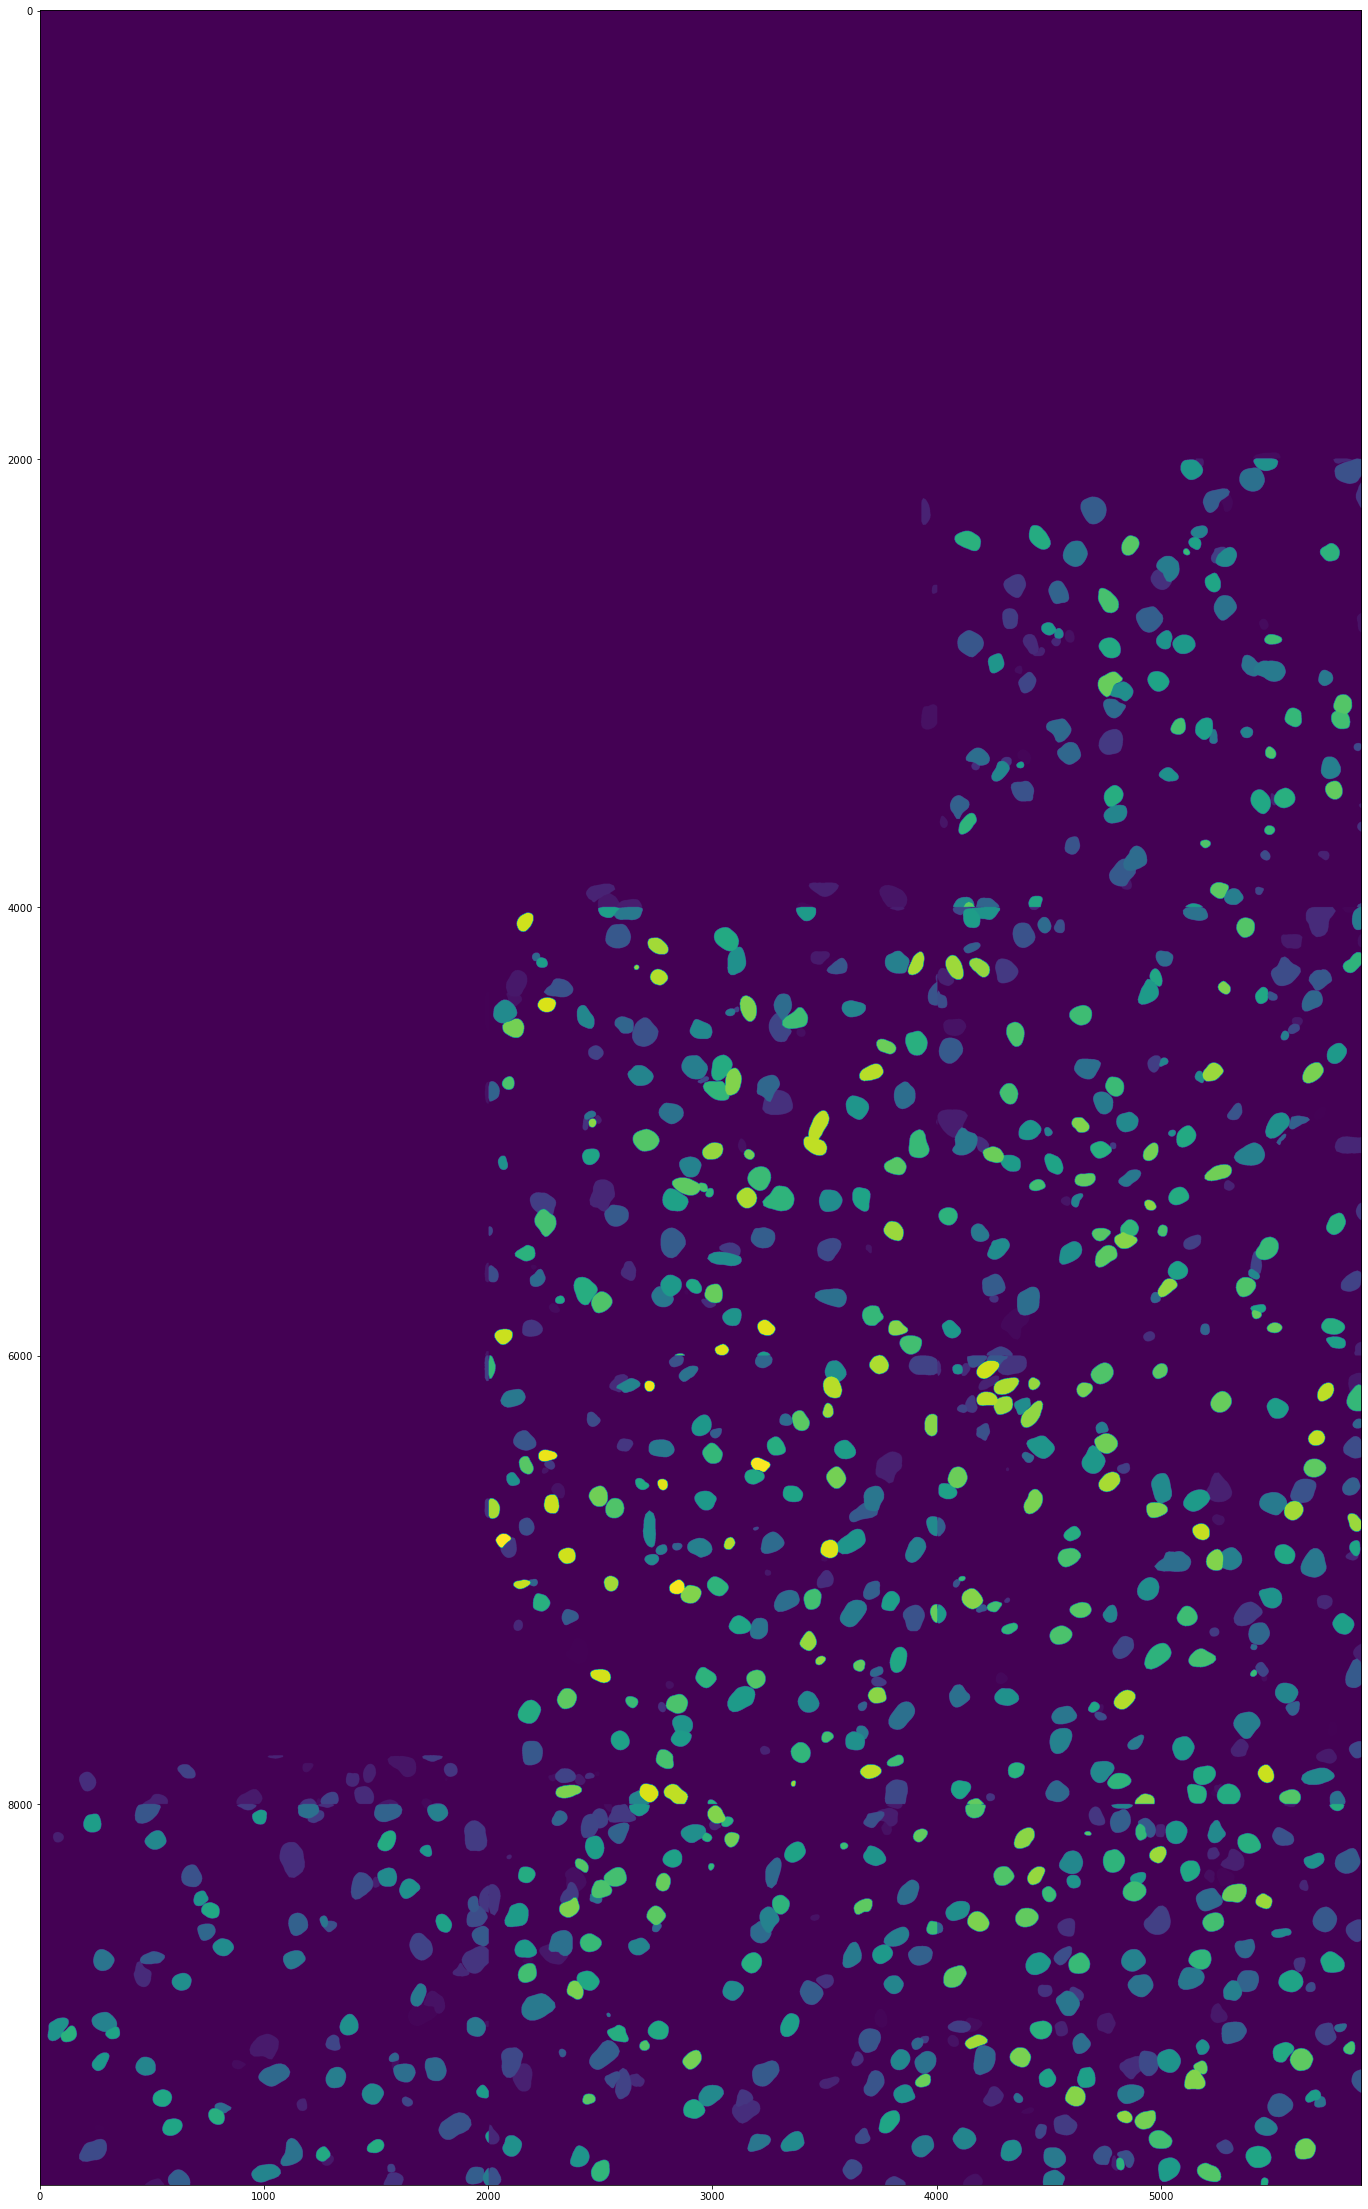

In [27]:
#overlaying labels onto the original

plt.figure(figsize=(40, 40))
#plt.imshow(canvas)
plt.imshow(overlay)

In [ ]:
imageio.imwrite('{}/DAPI_Overview_overlay.tif'.format(output_dir), overlay)

In [ ]:
saved_overlay = imageio.imread('{}/DAPI_Overview_overlay.tif'.format(output_dir))

plt.figure(figsize=(40, 40))
plt.imshow(saved_overlay, cmap='gray')

### Conclusion

The purpose of this image slicer module is to make possible the processing of large images by dividing them into smaller subimages and pushing each through the Stardist segmentation model. Typically, a 20000 X 20000 image would exact a large toll on computational resources, even on purpose-built machines. By applying this module, we hope to reduce cost and allow even personal machines with mid-range specs to get the job done.

However, this is not without its faults. As the image is evaluated by the model piecewise, there is an inherent risk of error with objects that are bifurcated along subimage tile edges. This causes inconsistencies with the shape of detected nuclei, and can affect total number of objects detected. A possible fix is to use binary images and by taking advantage of the built-in offsets within the grid to try and stitch together objects along gridlines.

Another issue is space. Intermediate steps require creating the subimage copies of the raw data, which means more storage needs to be allocated. However, this should be fixed as soon as the pipeline delivers consistent results, and the subimage tiles can simply be treated as temporary files that can be deleted as soon as the evaluation by stardist is complete.

Lastly is the subject of time. With further implementation, we hope to accelerate the process by optimization after frequent use.

#### Full disclosure on specs for local machine:
 - Intel Core i7-10875H CPU @ 2.30GHz, 8-core
 - 16GB RAM
 - NVIDIA RTX 2060 Max-Q

In [ ]:
#changing images into binary
#to demonstrate the issues of piecewise detection
# note the abrupt lines inbetween some cells
plt.figure(figsize=(30,30))
print(sample.shape)
overlay_mask = np.zeros((overlay.shape[0], overlay.shape[1]))
overlay_mask[overlay > 0] = 1

plt.imshow(overlay_mask)

### Mitigating the issues of piecewise segmentation

To correct the stitching errors, we constructed the subimage tiles to overlap with one another, so that we can isolate the stitch areas, and find the common results between two segmentation instances. We must then refine our process when iterating through each tile, since we must now keep track of their adjacency. For example, corner tiles are 2-adjacent, perimeter tiles are 3-adjacent, and inner tiles are 4-adjacent. We'll begin by reconfiguring our segmentation/analysis loop by adding in an intermediate step to convert results to binary

In [28]:
#creating new canvases

canvas = np.zeros((boundary[-1][1], boundary[-1][3]))
overlay = np.zeros((boundary[-1][1], boundary[-1][3]))

DAPI_Overview_processed_subimage_00001 1001 
 label_img_cell =  2164 overlay_cell =  0 

DAPI_Overview_processed_subimage_00002 2001 
 label_img_cell =  4473 overlay_cell =  0 

DAPI_Overview_processed_subimage_00002 2002 
 label_img_cell =  10201 overlay_cell =  0 

DAPI_Overview_processed_subimage_00002 2003 
 label_img_cell =  5968 overlay_cell =  0 

DAPI_Overview_processed_subimage_00002 2004 
 label_img_cell =  7862 overlay_cell =  0 

DAPI_Overview_processed_subimage_00002 2005 
 label_img_cell =  6796 overlay_cell =  0 

DAPI_Overview_processed_subimage_00004 4001 
 label_img_cell =  2856 overlay_cell =  0 

DAPI_Overview_processed_subimage_00004 4002 
 label_img_cell =  1664 overlay_cell =  0 

DAPI_Overview_processed_subimage_00004 4003 
 label_img_cell =  5472 overlay_cell =  0 

DAPI_Overview_processed_subimage_00004 4004 
 label_img_cell =  1006 overlay_cell =  0 

DAPI_Overview_processed_subimage_00004 4005 
 label_img_cell =  5422 overlay_cell =  0 

DAPI_Overview_proces

DAPI_Overview_processed_subimage_00005 5075 
 label_img_cell =  6359 overlay_cell =  0 

DAPI_Overview_processed_subimage_00005 5076 
 label_img_cell =  2835 overlay_cell =  0 

DAPI_Overview_processed_subimage_00005 5077 
 label_img_cell =  760 overlay_cell =  0 

DAPI_Overview_processed_subimage_00005 5078 
 label_img_cell =  6005 overlay_cell =  0 

DAPI_Overview_processed_subimage_00005 5079 
 label_img_cell =  2390 overlay_cell =  0 

DAPI_Overview_processed_subimage_00005 5080 
 label_img_cell =  6589 overlay_cell =  0 

DAPI_Overview_processed_subimage_00005 5081 
 label_img_cell =  4595 overlay_cell =  0 

DAPI_Overview_processed_subimage_00005 5082 
 label_img_cell =  7185 overlay_cell =  0 

DAPI_Overview_processed_subimage_00005 5083 
 label_img_cell =  3098 overlay_cell =  0 

DAPI_Overview_processed_subimage_00005 5084 
 label_img_cell =  6836 overlay_cell =  0 

DAPI_Overview_processed_subimage_00005 5085 
 label_img_cell =  7336 overlay_cell =  0 

DAPI_Overview_processe

 label_img_cell =  6009 overlay_cell =  0 

DAPI_Overview_processed_subimage_00007 7057 
 label_img_cell =  2969 overlay_cell =  0 

DAPI_Overview_processed_subimage_00007 7058 
 label_img_cell =  1138 overlay_cell =  0 

DAPI_Overview_processed_subimage_00007 7059 
 label_img_cell =  9513 overlay_cell =  0 

DAPI_Overview_processed_subimage_00007 7060 
 label_img_cell =  8358 overlay_cell =  0 

DAPI_Overview_processed_subimage_00007 7061 
 label_img_cell =  6962 overlay_cell =  0 

DAPI_Overview_processed_subimage_00007 7062 
 label_img_cell =  7770 overlay_cell =  0 

DAPI_Overview_processed_subimage_00007 7063 
 label_img_cell =  6122 overlay_cell =  0 

DAPI_Overview_processed_subimage_00007 7064 
 label_img_cell =  5832 overlay_cell =  0 

DAPI_Overview_processed_subimage_00007 7065 
 label_img_cell =  6636 overlay_cell =  0 

DAPI_Overview_processed_subimage_00007 7066 
 label_img_cell =  8176 overlay_cell =  0 

DAPI_Overview_processed_subimage_00007 7067 
 label_img_cell =  81

DAPI_Overview_processed_subimage_00008 8025 
 label_img_cell =  3372 overlay_cell =  0 

DAPI_Overview_processed_subimage_00008 8026 
 label_img_cell =  3902 overlay_cell =  0 

DAPI_Overview_processed_subimage_00008 8027 
 label_img_cell =  6278 overlay_cell =  0 

DAPI_Overview_processed_subimage_00008 8028 
 label_img_cell =  3159 overlay_cell =  0 

DAPI_Overview_processed_subimage_00008 8029 
 label_img_cell =  6897 overlay_cell =  0 

DAPI_Overview_processed_subimage_00008 8030 
 label_img_cell =  1792 overlay_cell =  0 

DAPI_Overview_processed_subimage_00008 8031 
 label_img_cell =  1681 overlay_cell =  0 

DAPI_Overview_processed_subimage_00008 8032 
 label_img_cell =  11157 overlay_cell =  0 

DAPI_Overview_processed_subimage_00008 8033 
 label_img_cell =  2485 overlay_cell =  0 

DAPI_Overview_processed_subimage_00008 8034 
 label_img_cell =  2311 overlay_cell =  0 

DAPI_Overview_processed_subimage_00008 8035 
 label_img_cell =  8697 overlay_cell =  0 

DAPI_Overview_proces

DAPI_Overview_processed_subimage_00008 8119 
 label_img_cell =  4907 overlay_cell =  0 

DAPI_Overview_processed_subimage_00009 9001 
 label_img_cell =  911 overlay_cell =  0 

DAPI_Overview_processed_subimage_00009 9002 
 label_img_cell =  139 overlay_cell =  0 

DAPI_Overview_processed_subimage_00009 9003 
 label_img_cell =  1519 overlay_cell =  0 

DAPI_Overview_processed_subimage_00009 9004 
 label_img_cell =  1176 overlay_cell =  0 

DAPI_Overview_processed_subimage_00009 9005 
 label_img_cell =  1764 overlay_cell =  0 

DAPI_Overview_processed_subimage_00009 9006 
 label_img_cell =  1587 overlay_cell =  0 

DAPI_Overview_processed_subimage_00009 9007 
 label_img_cell =  6694 overlay_cell =  0 

DAPI_Overview_processed_subimage_00009 9008 
 label_img_cell =  8308 overlay_cell =  0 

DAPI_Overview_processed_subimage_00009 9009 
 label_img_cell =  9476 overlay_cell =  0 

DAPI_Overview_processed_subimage_00009 9010 
 label_img_cell =  7675 overlay_cell =  0 

DAPI_Overview_processed

DAPI_Overview_processed_subimage_00010 10071 
 label_img_cell =  5562 overlay_cell =  0 

DAPI_Overview_processed_subimage_00010 10072 
 label_img_cell =  9496 overlay_cell =  0 

DAPI_Overview_processed_subimage_00010 10073 
 label_img_cell =  6429 overlay_cell =  0 

DAPI_Overview_processed_subimage_00010 10074 
 label_img_cell =  6294 overlay_cell =  0 

DAPI_Overview_processed_subimage_00010 10075 
 label_img_cell =  10049 overlay_cell =  0 

DAPI_Overview_processed_subimage_00010 10076 
 label_img_cell =  4997 overlay_cell =  0 

DAPI_Overview_processed_subimage_00010 10077 
 label_img_cell =  6184 overlay_cell =  0 

DAPI_Overview_processed_subimage_00010 10078 
 label_img_cell =  5440 overlay_cell =  0 

DAPI_Overview_processed_subimage_00010 10079 
 label_img_cell =  5546 overlay_cell =  0 

DAPI_Overview_processed_subimage_00010 10080 
 label_img_cell =  5232 overlay_cell =  0 

DAPI_Overview_processed_subimage_00010 10081 
 label_img_cell =  6179 overlay_cell =  0 

DAPI_Over

DAPI_Overview_processed_subimage_00011 11028 
 label_img_cell =  1311 overlay_cell =  0 

DAPI_Overview_processed_subimage_00011 11029 
 label_img_cell =  2659 overlay_cell =  0 

DAPI_Overview_processed_subimage_00011 11030 
 label_img_cell =  6971 overlay_cell =  0 

DAPI_Overview_processed_subimage_00011 11031 
 label_img_cell =  3539 overlay_cell =  0 

DAPI_Overview_processed_subimage_00011 11032 
 label_img_cell =  6449 overlay_cell =  0 

DAPI_Overview_processed_subimage_00011 11033 
 label_img_cell =  1562 overlay_cell =  0 

DAPI_Overview_processed_subimage_00011 11034 
 label_img_cell =  3374 overlay_cell =  0 

DAPI_Overview_processed_subimage_00011 11035 
 label_img_cell =  9500 overlay_cell =  0 

DAPI_Overview_processed_subimage_00011 11036 
 label_img_cell =  3543 overlay_cell =  0 

DAPI_Overview_processed_subimage_00011 11037 
 label_img_cell =  878 overlay_cell =  0 

DAPI_Overview_processed_subimage_00011 11038 
 label_img_cell =  2203 overlay_cell =  0 

DAPI_Overvi

DAPI_Overview_processed_subimage_00011 11120 
 label_img_cell =  6298 overlay_cell =  0 

DAPI_Overview_processed_subimage_00011 11121 
 label_img_cell =  6289 overlay_cell =  0 

DAPI_Overview_processed_subimage_00011 11122 
 label_img_cell =  5991 overlay_cell =  0 

DAPI_Overview_processed_subimage_00011 11123 
 label_img_cell =  4773 overlay_cell =  0 

DAPI_Overview_processed_subimage_00011 11124 
 label_img_cell =  4566 overlay_cell =  0 

DAPI_Overview_processed_subimage_00011 11125 
 label_img_cell =  4044 overlay_cell =  0 

DAPI_Overview_processed_subimage_00011 11126 
 label_img_cell =  4473 overlay_cell =  0 

DAPI_Overview_processed_subimage_00011 11127 
 label_img_cell =  4477 overlay_cell =  0 

DAPI_Overview_processed_subimage_00011 11128 
 label_img_cell =  5803 overlay_cell =  0 

DAPI_Overview_processed_subimage_00012 12001 
 label_img_cell =  879 overlay_cell =  0 

DAPI_Overview_processed_subimage_00012 12002 
 label_img_cell =  9061 overlay_cell =  0 

DAPI_Overvi

DAPI_Overview_processed_subimage_00013 13001 
 label_img_cell =  586 overlay_cell =  0 

DAPI_Overview_processed_subimage_00013 13002 
 label_img_cell =  3726 overlay_cell =  0 

DAPI_Overview_processed_subimage_00013 13003 
 label_img_cell =  899 overlay_cell =  0 

DAPI_Overview_processed_subimage_00013 13004 
 label_img_cell =  978 overlay_cell =  0 

DAPI_Overview_processed_subimage_00013 13005 
 label_img_cell =  6407 overlay_cell =  0 

DAPI_Overview_processed_subimage_00013 13006 
 label_img_cell =  1897 overlay_cell =  0 

DAPI_Overview_processed_subimage_00013 13007 
 label_img_cell =  931 overlay_cell =  0 

DAPI_Overview_processed_subimage_00013 13008 
 label_img_cell =  1774 overlay_cell =  0 

DAPI_Overview_processed_subimage_00013 13009 
 label_img_cell =  5955 overlay_cell =  0 

DAPI_Overview_processed_subimage_00013 13010 
 label_img_cell =  1101 overlay_cell =  0 

DAPI_Overview_processed_subimage_00013 13011 
 label_img_cell =  4711 overlay_cell =  0 

DAPI_Overview_

DAPI_Overview_processed_subimage_00013 13105 
 label_img_cell =  2834 overlay_cell =  0 

DAPI_Overview_processed_subimage_00013 13106 
 label_img_cell =  4201 overlay_cell =  0 

DAPI_Overview_processed_subimage_00013 13107 
 label_img_cell =  3189 overlay_cell =  0 

DAPI_Overview_processed_subimage_00013 13108 
 label_img_cell =  3420 overlay_cell =  0 

DAPI_Overview_processed_subimage_00013 13109 
 label_img_cell =  5205 overlay_cell =  0 

DAPI_Overview_processed_subimage_00013 13110 
 label_img_cell =  4662 overlay_cell =  0 

DAPI_Overview_processed_subimage_00013 13111 
 label_img_cell =  5637 overlay_cell =  0 

DAPI_Overview_processed_subimage_00013 13112 
 label_img_cell =  4749 overlay_cell =  0 

DAPI_Overview_processed_subimage_00014 14001 
 label_img_cell =  937 overlay_cell =  0 

DAPI_Overview_processed_subimage_00014 14002 
 label_img_cell =  4814 overlay_cell =  0 

DAPI_Overview_processed_subimage_00014 14003 
 label_img_cell =  1165 overlay_cell =  0 

DAPI_Overvi

DAPI_Overview_processed_subimage_00014 14100 
 label_img_cell =  6077 overlay_cell =  0 

DAPI_Overview_processed_subimage_00014 14101 
 label_img_cell =  6620 overlay_cell =  0 

DAPI_Overview_processed_subimage_00014 14102 
 label_img_cell =  457 overlay_cell =  0 

DAPI_Overview_processed_subimage_00014 14103 
 label_img_cell =  7585 overlay_cell =  0 

DAPI_Overview_processed_subimage_00014 14104 
 label_img_cell =  7959 overlay_cell =  0 

DAPI_Overview_processed_subimage_00014 14105 
 label_img_cell =  6883 overlay_cell =  0 

DAPI_Overview_processed_subimage_00014 14106 
 label_img_cell =  2646 overlay_cell =  0 

DAPI_Overview_processed_subimage_00014 14107 
 label_img_cell =  7292 overlay_cell =  0 

DAPI_Overview_processed_subimage_00014 14108 
 label_img_cell =  6947 overlay_cell =  0 

DAPI_Overview_processed_subimage_00014 14109 
 label_img_cell =  6129 overlay_cell =  0 

DAPI_Overview_processed_subimage_00014 14110 
 label_img_cell =  6386 overlay_cell =  0 

DAPI_Overvi

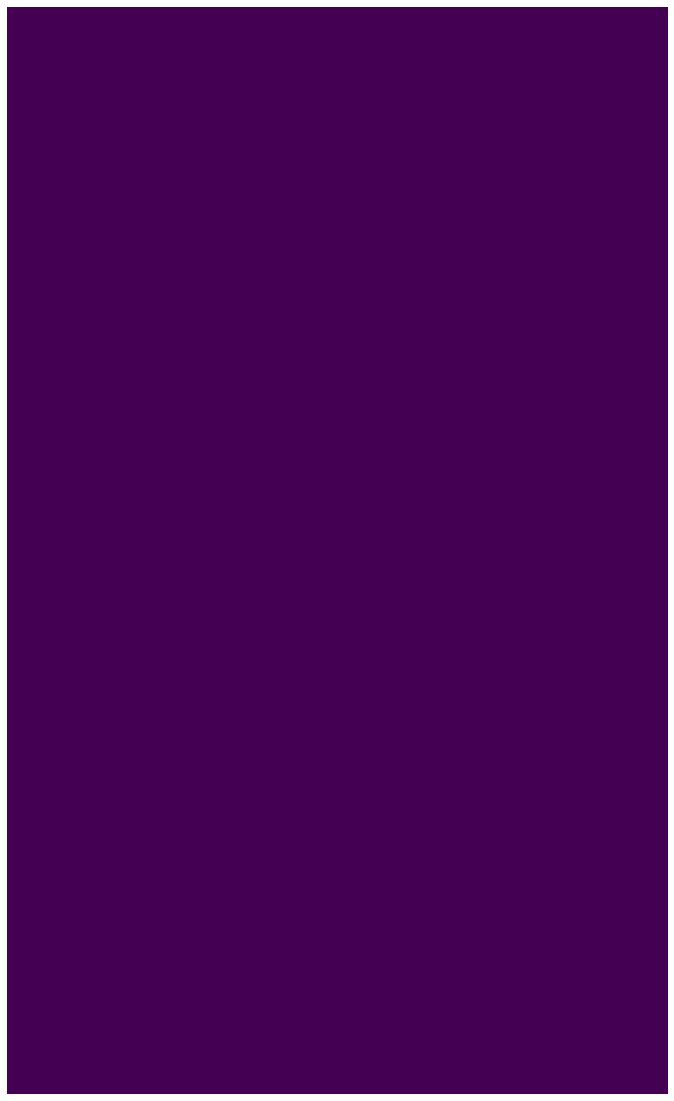

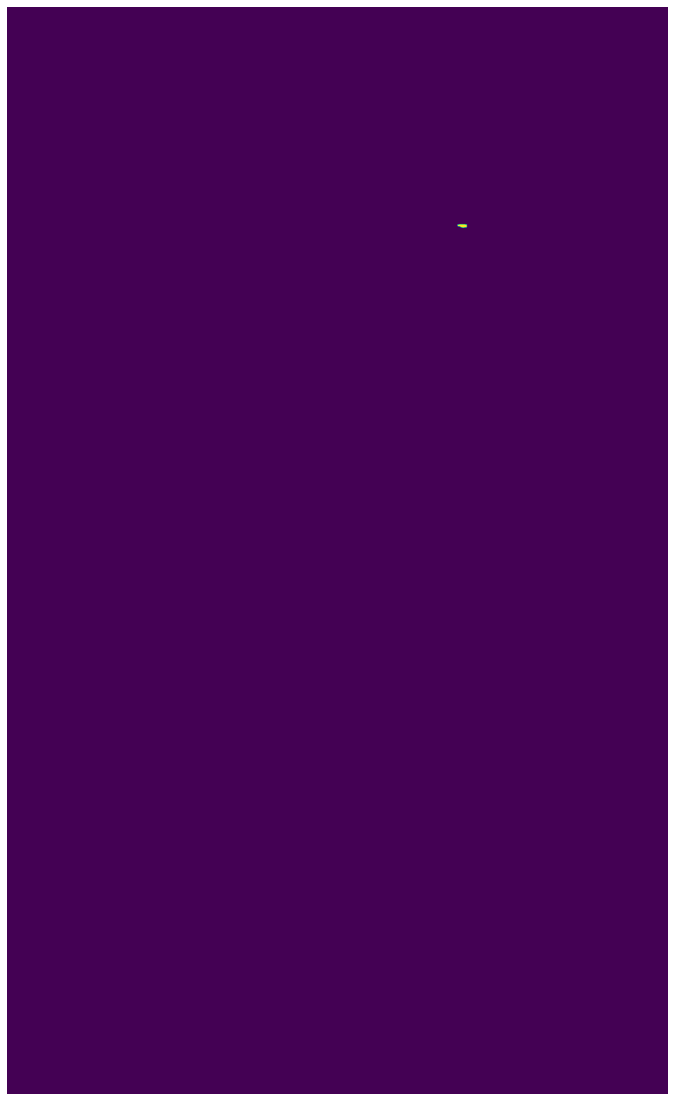

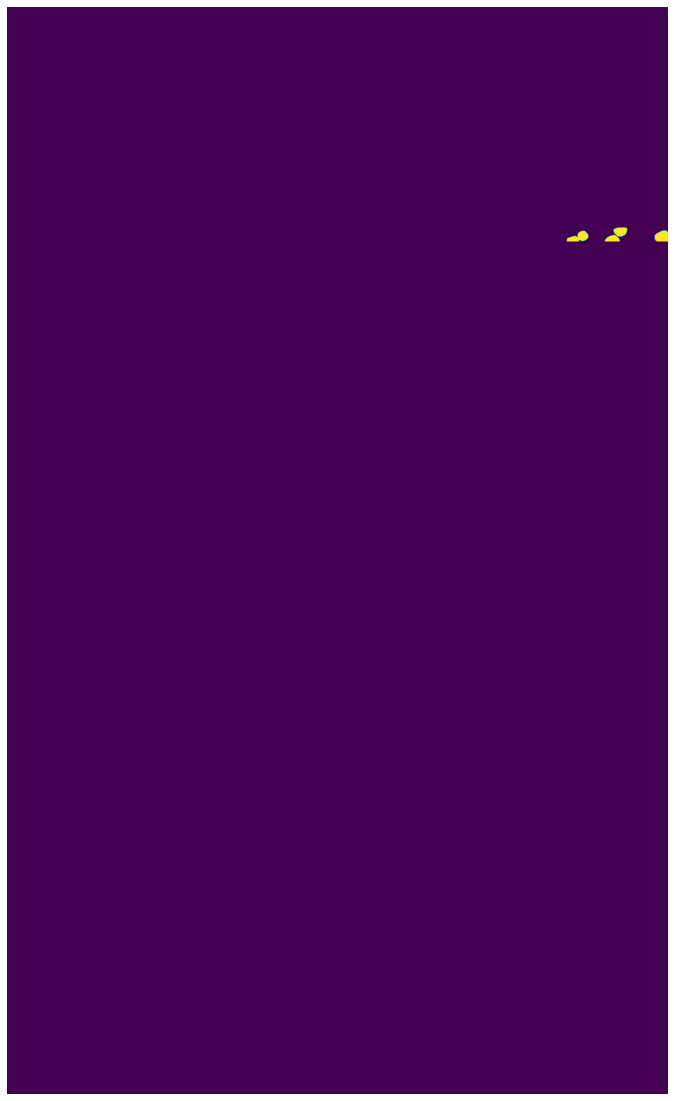

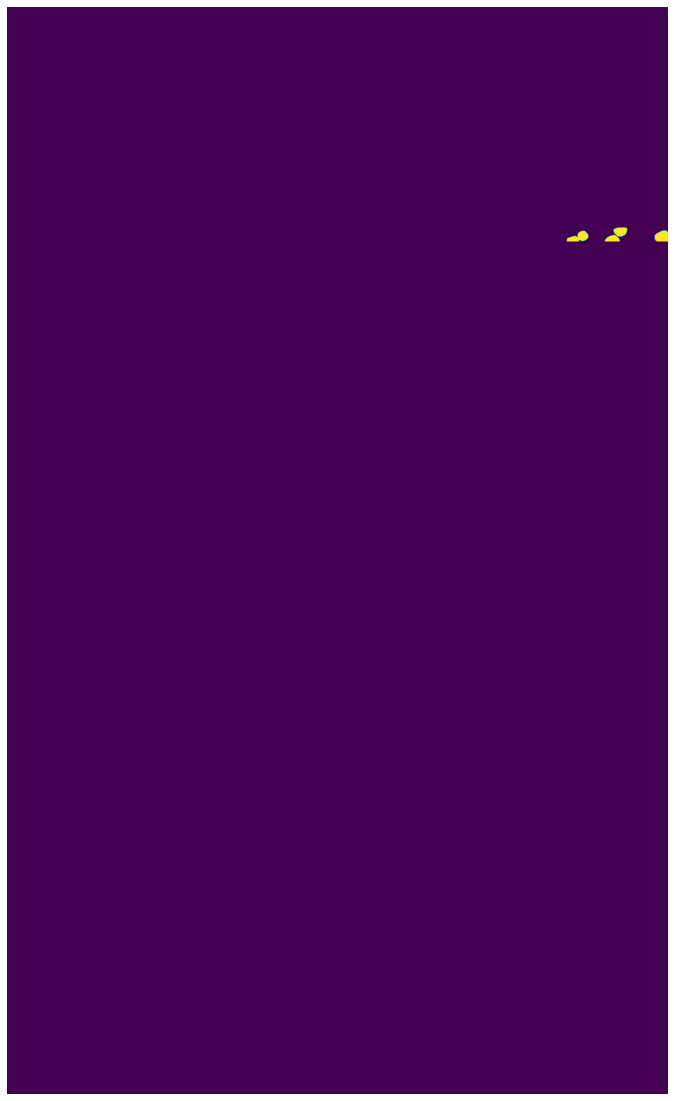

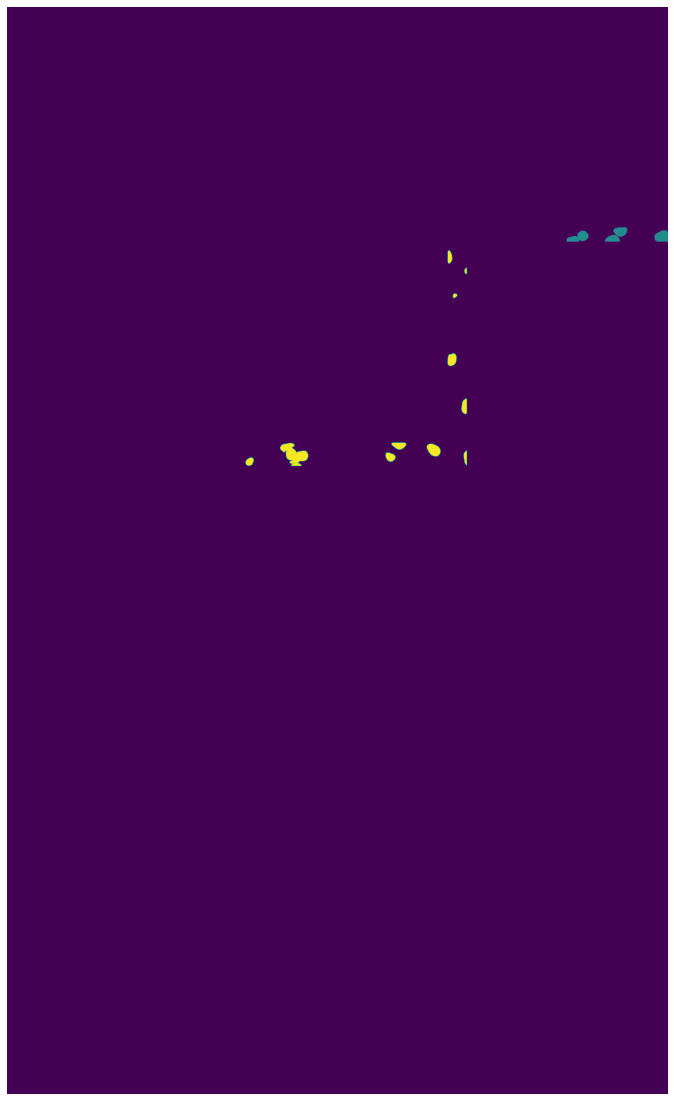

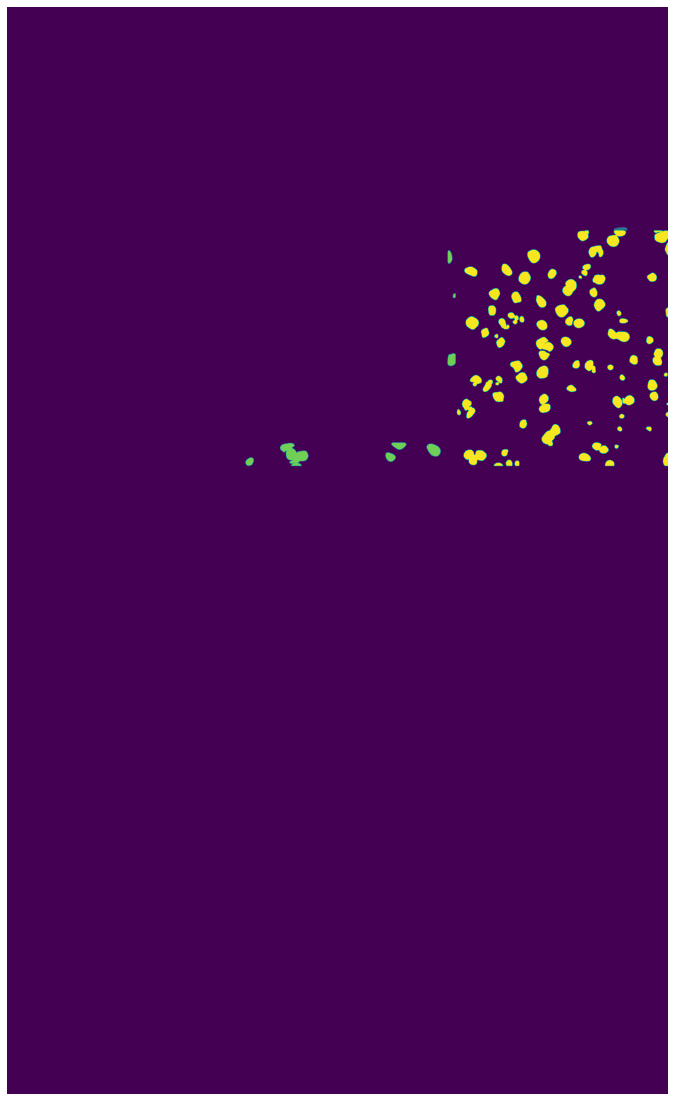

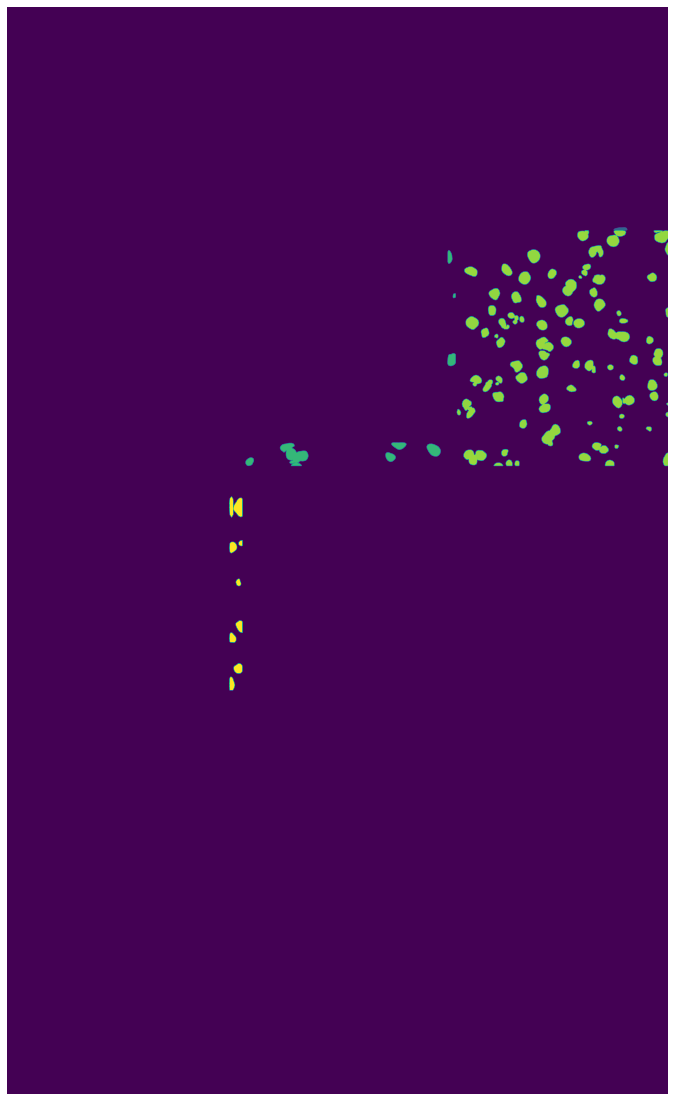

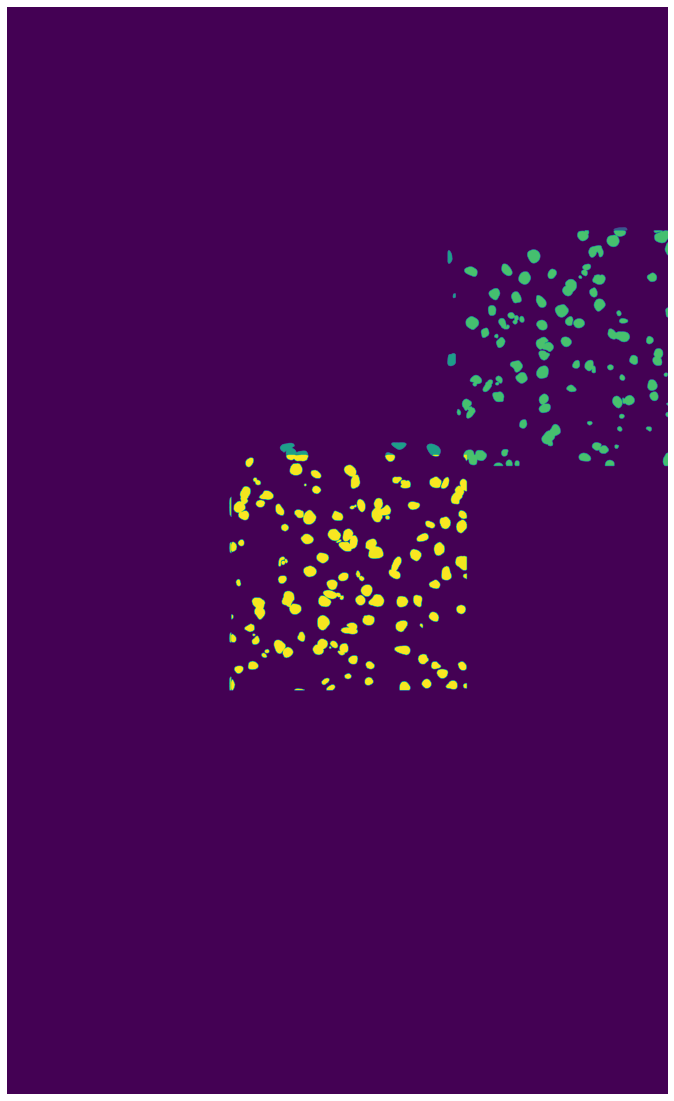

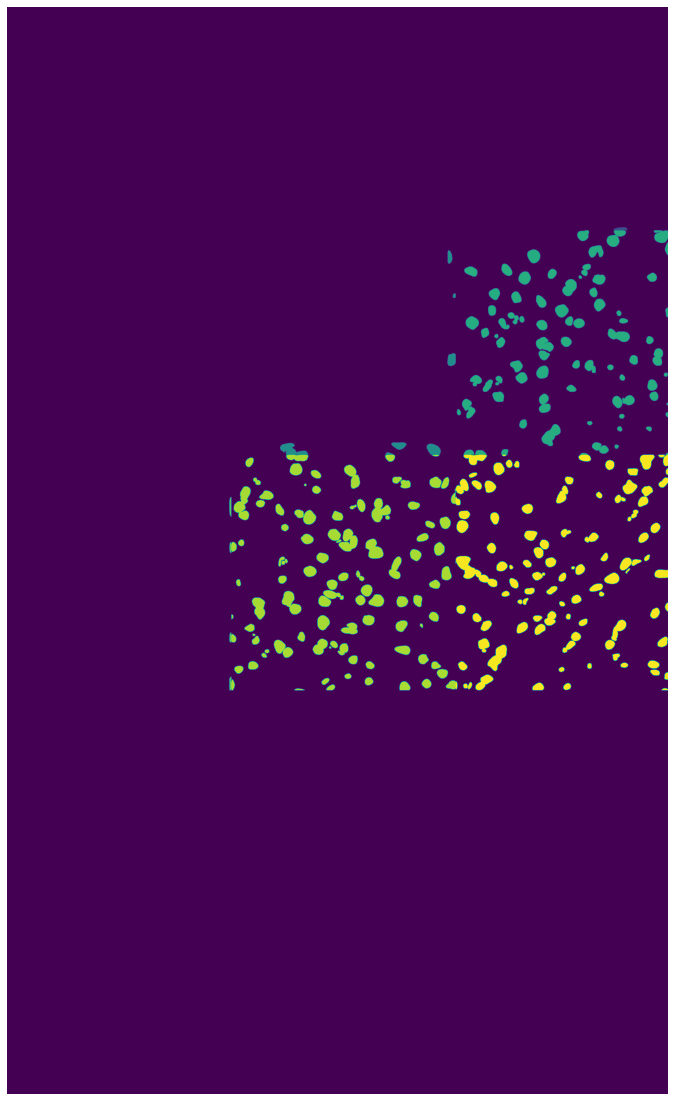

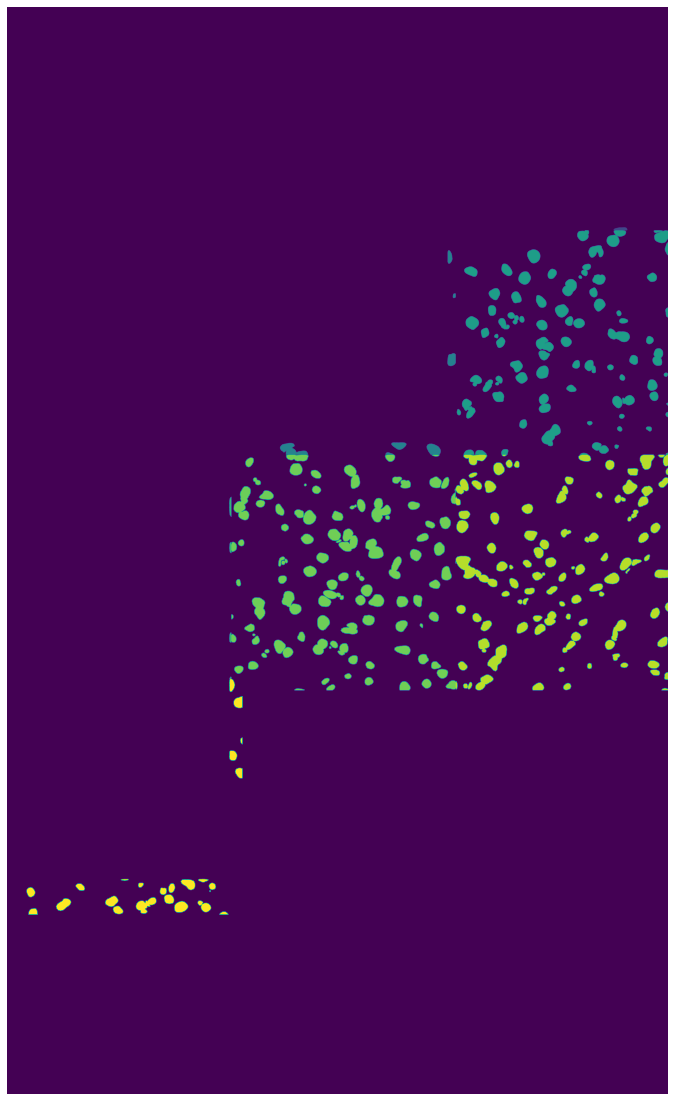

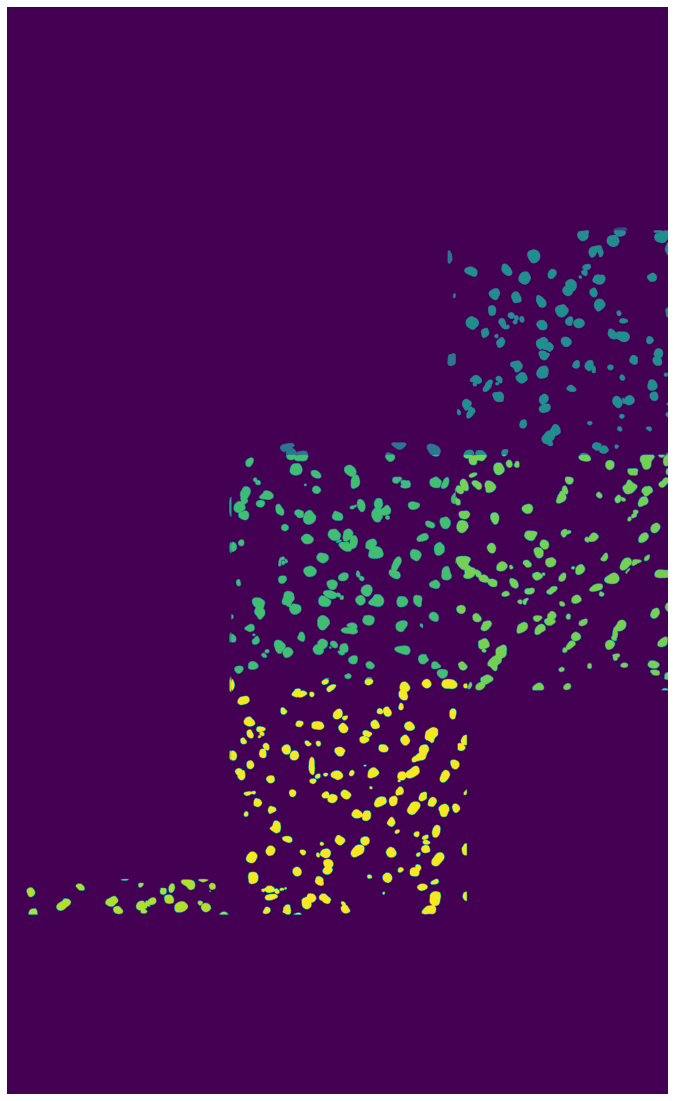

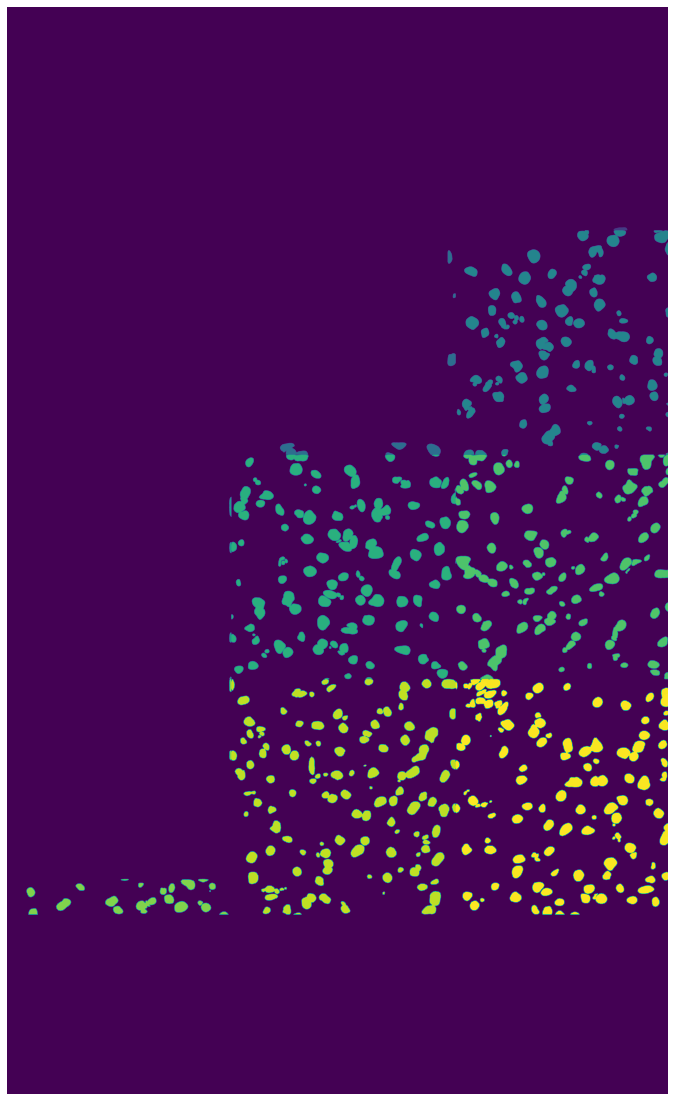

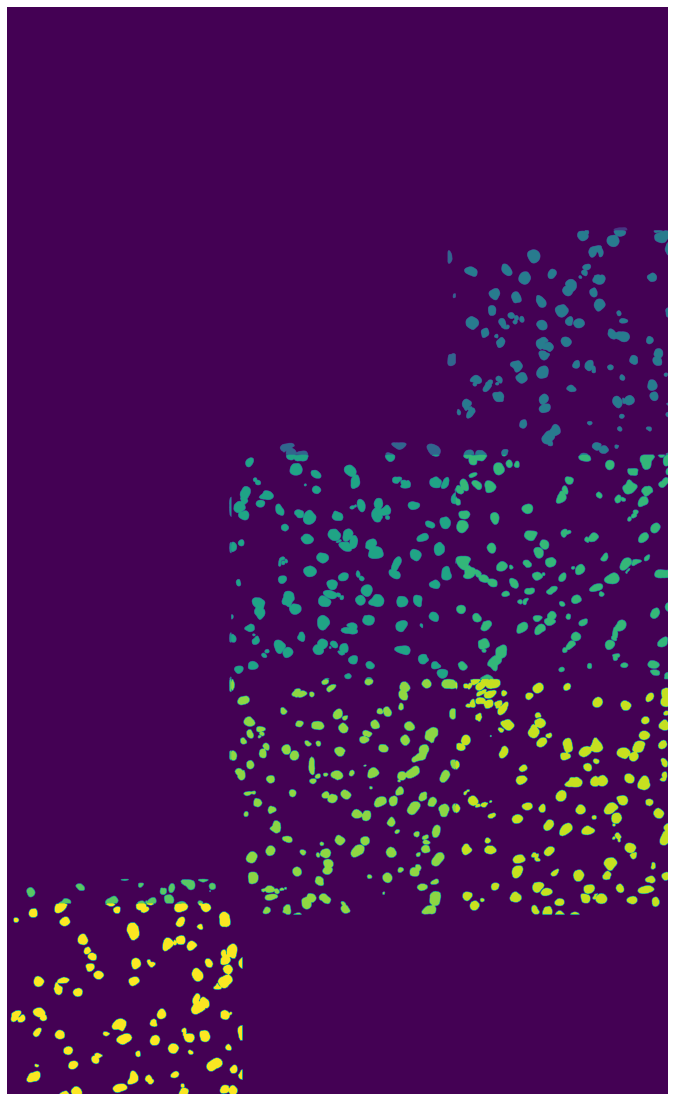

In [ ]:
#reduced loop for testing overlap isolation

start = time.time()

cells_detected = 0

for i, key in enumerate(overlay_pos):
    
    tile_offset = 1000*i
    current_file = str(processed_dir+'/'+'{}.tif'.format(str(key)))
    label_img = imageio.imread(processed_dir+'/'+'{}.tif'.format(str(key)))
    
    #introducing an offset to uniquely identify individual tiles
    label_img = label_img + tile_offset
    label_img[label_img == tile_offset] = 0
    
    current_subsample = overlay[overlay_pos[key][0]:overlay_pos[key][1], overlay_pos[key][2]:overlay_pos[key][3]]
    
    for ii in np.unique(label_img):

        if ii == 0:
            continue
        
        size_in_tile = np.count_nonzero(label_img == ii)
        size_in_overlap = np.count_nonzero(current_subsample == ii)
        
        if size_in_tile > size_in_overlap:
            current_subsample[current_subsample == ii] = 0
        
        elif size_in_tile == size_in_overlap:
            continue
        
        else:
            label_img[label_img == ii] = 0
          
        print(key, ii,'\n',
              'label_img_cell = ', size_in_tile,
              'overlay_cell = ', size_in_overlap, '\n')
            
    overlay[overlay_pos[key][0]:overlay_pos[key][1], overlay_pos[key][2]:overlay_pos[key][3]] = label_img

    
    plt.figure(figsize=(20,20))
    plt.imshow(overlay)       
    plt.axis('off')
    
    #recording number of detected objects
    #cells_detected = cells_detected + int(len(details['coord']))
    #mean_cell_per_slice = cells_detected / int(len(img_list))

    #constructing stiched predictions from binary label masks
    #current_subsample = np.logical_or(current_subsample, labels > 0)

process_time = time.time() - start
print(process_time)

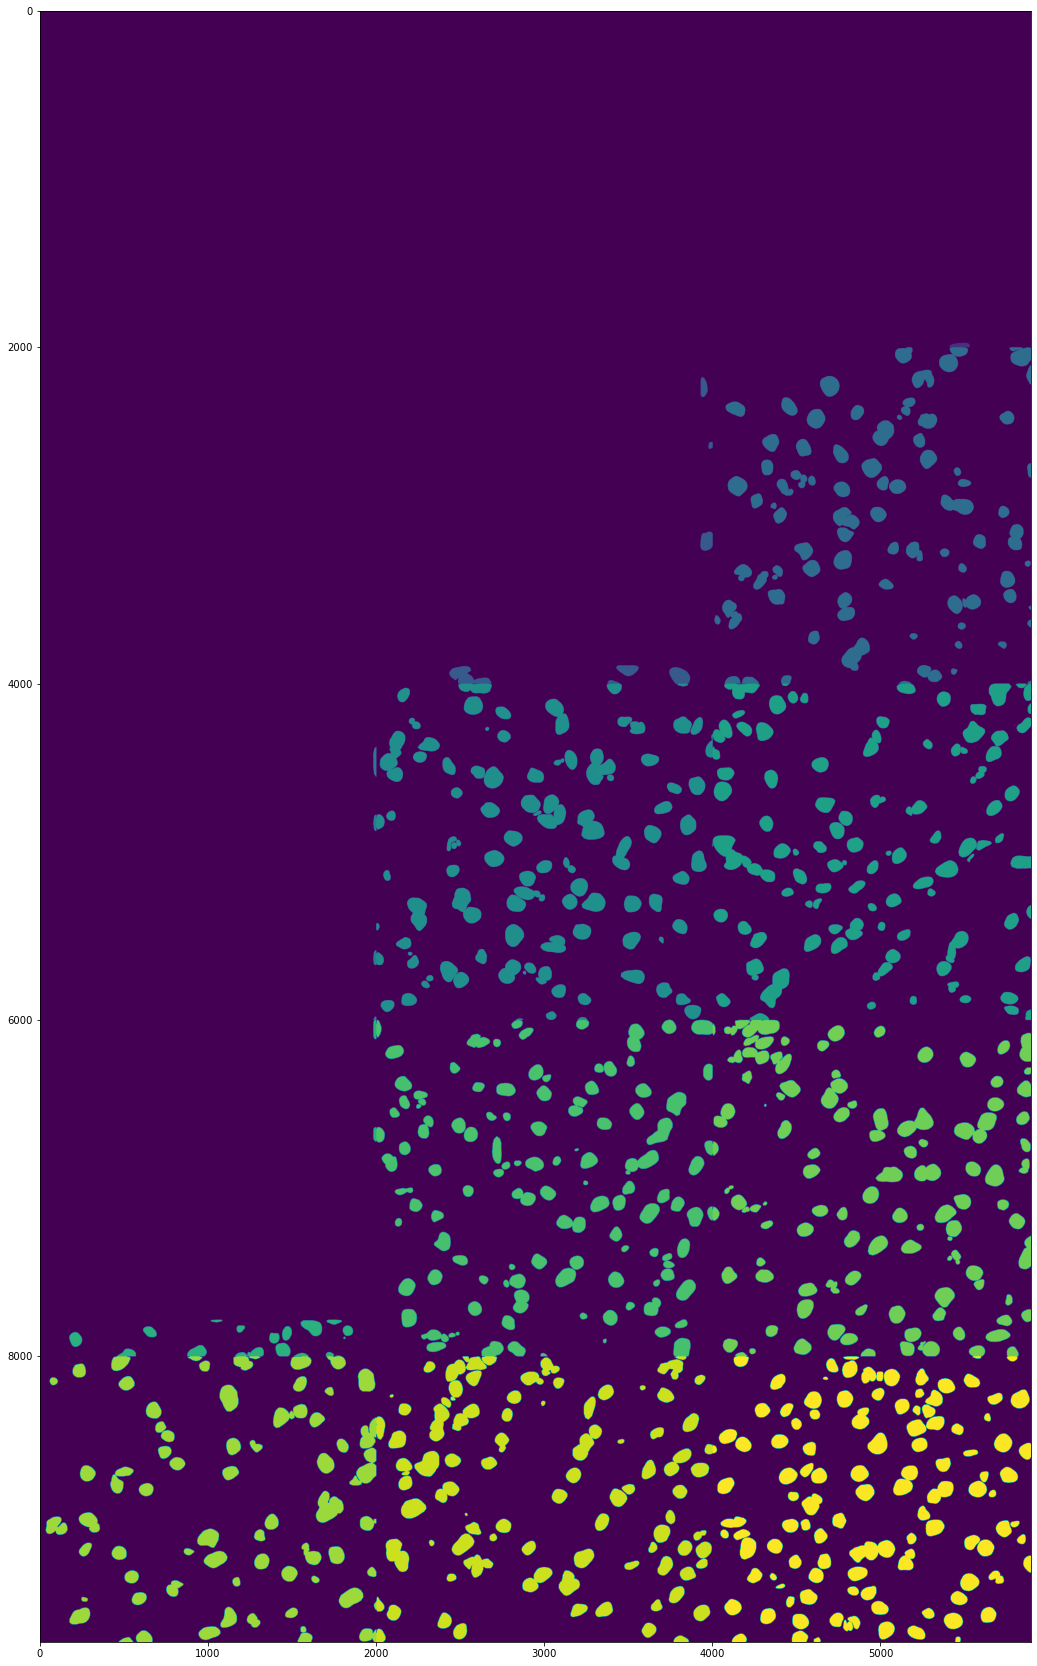

In [81]:
plt.figure(figsize=(30,30))
plt.imshow(overlay)

# Miscellaneous code

In [ ]:
def get_nth_image(dictionary, n=0):
    
    if n < 0:
        n += len(dictionary)
    
    for i, key in enumerate(dictionary.keys()):
        if i == n:
            return key
        
    raise IndexError("dictionary index out of range")

In [ ]:
def get_image_coordinates(dictionary, n=0):
    
    if n < 0:
        n += len(dictionary)
    
    for i, key in enumerate(dictionary.keys()):
        if i == n:
            return dictionary[key]
        
    raise IndexError("dictionary index out of range")

In [ ]:
start = time.time()

cells_detected = 0
cell_location = {}

for key in coordinates:
            
    #getting predictions
    sample = imageio.imread(output_dir+'/'+'{}.tif'.format(str(key)))
    sample = normalize(sample, 1, 99.8, axis=axis_norm)
    labels, details = model.predict_instances(sample)
    
    #recording number of detected objects
    cells_detected = cells_detected + int(len(details['coord']))
    mean_cell_per_slice = cells_detected / int(len(img_list))

    #constructing stiched predictions from binary label masks
    overlay[coordinates[key][0]:coordinates[key][1], coordinates[key][2]:coordinates[key][3]] = np.logical_or(overlay[coordinates[key][0]:coordinates[key][1], coordinates[key][2]:coordinates[key][3]], labels > 0)
    
    #exclude tiles that contain no cells
    if len(details['points']) != 0:
    
        #construct a dictionary containing detected cells and their locations in the subimage
        #coordinates denote center of mass
        cell_location[key[-5:]] = [cell for cell in enumerate(details['points'])]

process_time = time.time() - start
print(process_time)

In [ ]:
plt.figure(figsize=(30,30))
plt.imshow(overlay)

print(cells_detected)
print(mean_cell_per_slice)